In [2]:
import numpy as np
from sklearn.mixture import GaussianMixture

from sklearn import datasets

import torch

import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def make_gmm(n_comps, n_dims):
  section_size = n_dims // n_comps
  means = np.zeros((n_comps, n_dims))
  for i in range(n_comps):
    means[i][i*section_size:(i+1)*section_size] = 1
  data = np.zeros((10000,n_dims))
  for i in range(10000):
    data[i] = means[i%n_comps] + np.random.randn(n_dims)*.3
  gmm = GaussianMixture(n_comps)

  return gmm.fit(data)
# gmm = make_gmm(3,3)
# print(f'{np.round(gmm.means_,2)}')
# print(f'{np.round(gmm.weights_,2)}')
# print(f'{np.round(gmm.covariances_,2)}')

In [3]:
# data = datasets.load_digits()['data']
# gmm = GaussianMixture(10, 'full', max_iter=50000)
# gmm = gmm.fit(data)
# samples = gmm.sample(10)

# for i in range(10):
#   plt.imshow(samples[0][i].reshape((8,8)), cmap='gray')
#   plt.title(samples[1][i])
#   plt.show()

# for i in range(10):
#   digit = gmm.means_[i]
#   plt.imshow(digit.reshape((8,8)), cmap='gray')
#   plt.show()

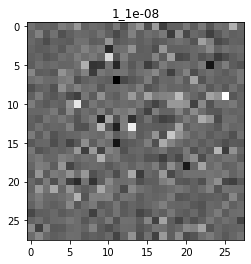

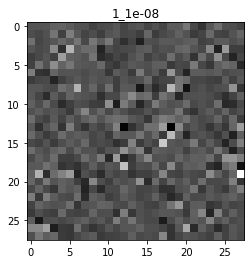

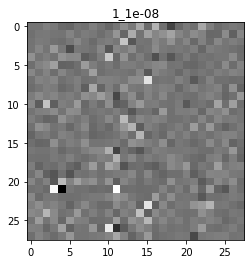

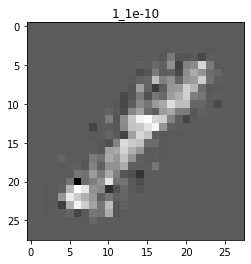

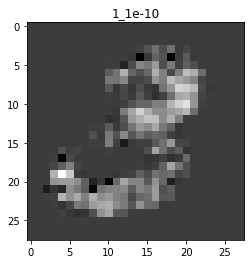

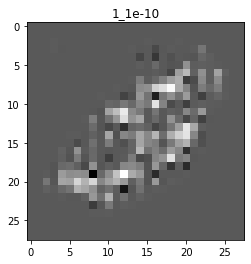

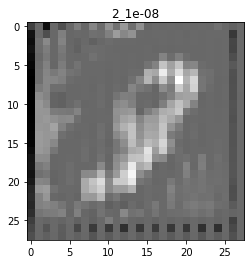

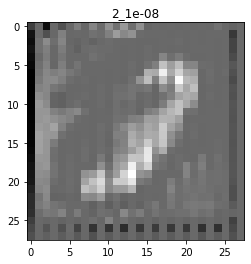

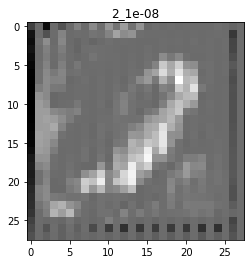

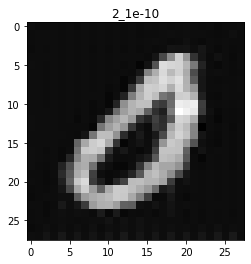

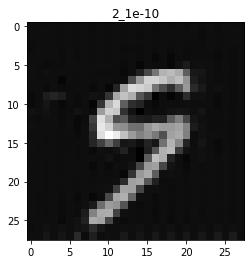

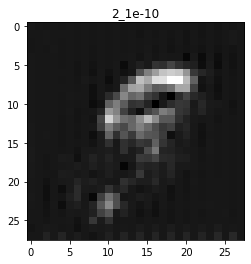

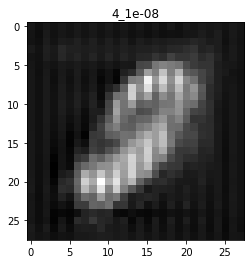

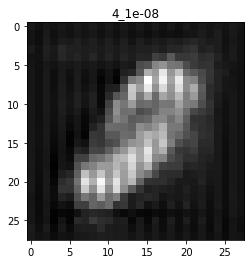

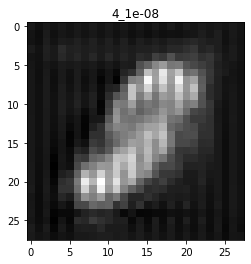

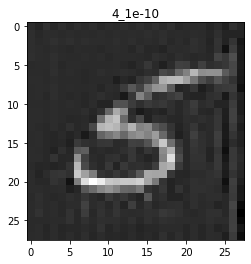

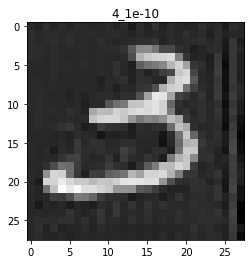

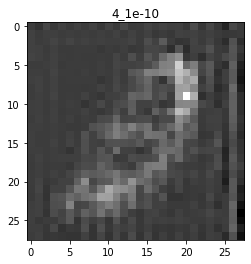

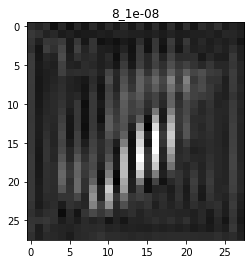

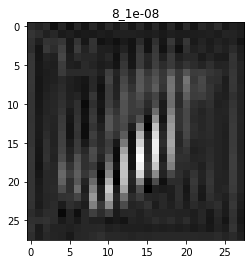

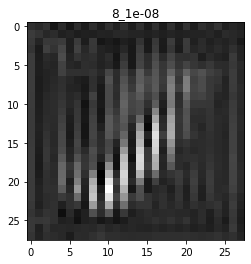

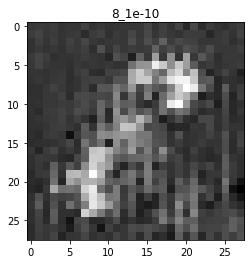

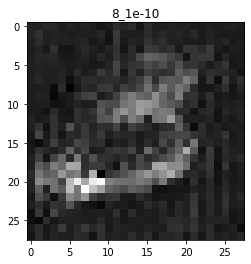

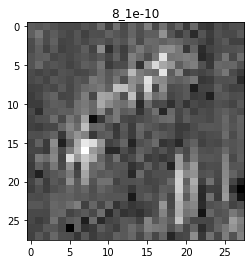

In [5]:
for size in [1,2,4,8]:
    for lr in ['1e-08','1e-10']:
        with open(f'chkpt/mnist_gmm_samples_{size}_{lr}.pickle','rb') as in_file:
            samples = pickle.load(in_file)['sample']
        for sample in samples[:3]:
            plt.imshow(sample[0], cmap='gray')
            plt.title(f'{size}_{lr}')
            plt.show()

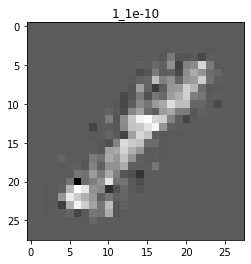

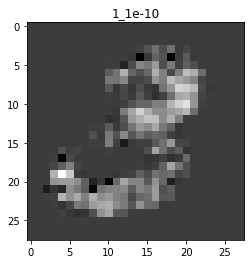

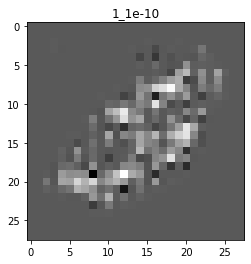

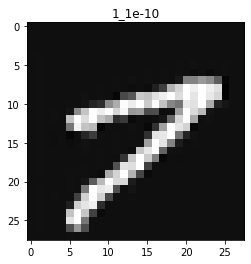

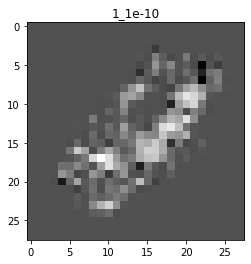

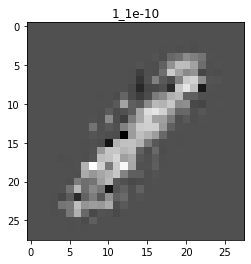

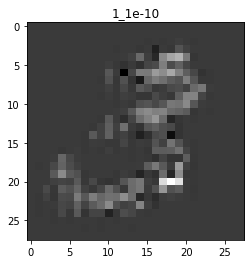

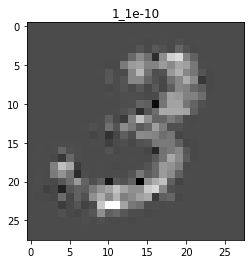

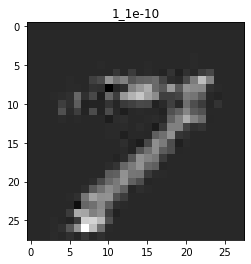

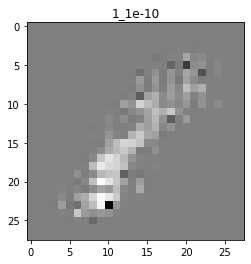

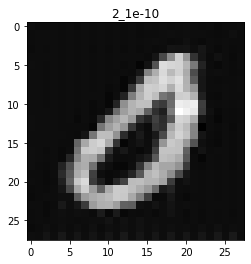

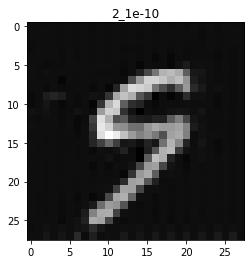

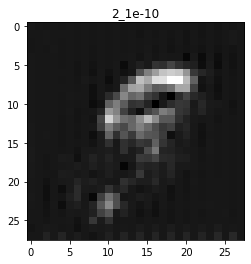

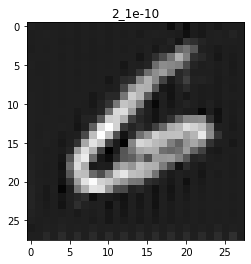

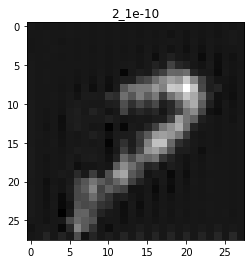

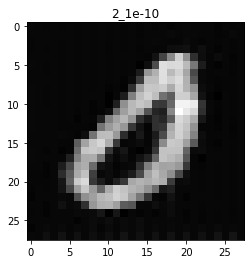

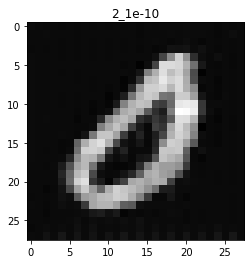

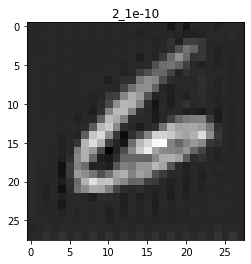

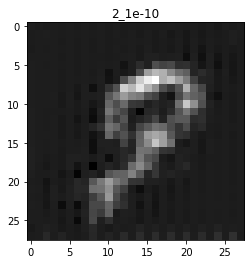

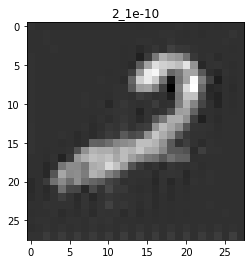

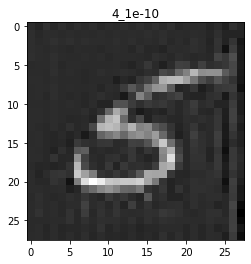

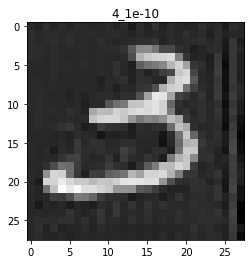

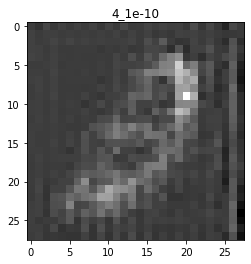

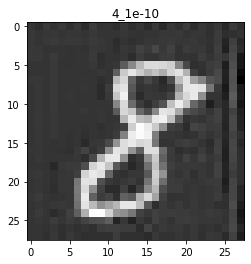

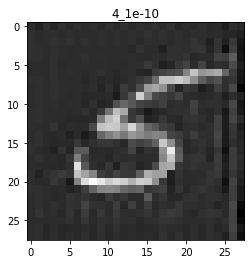

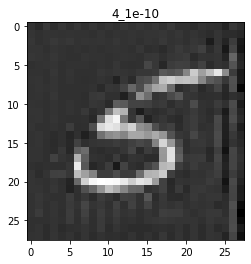

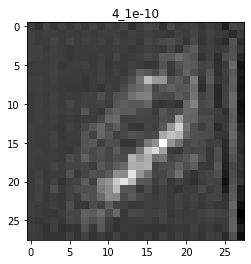

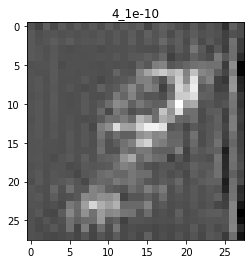

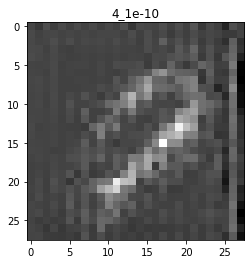

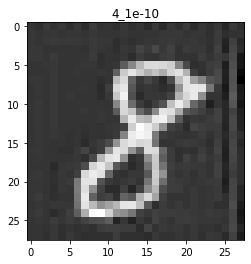

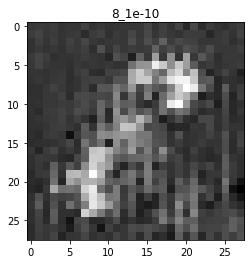

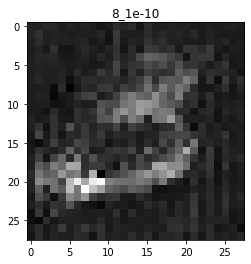

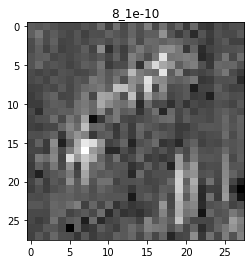

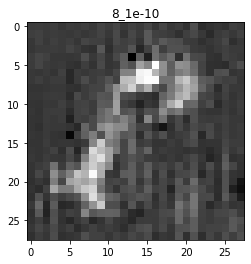

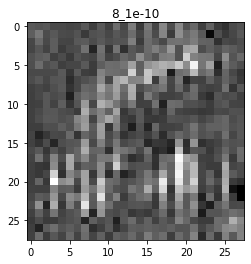

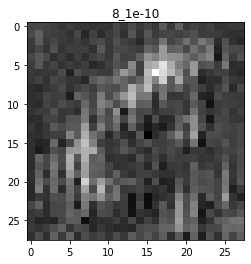

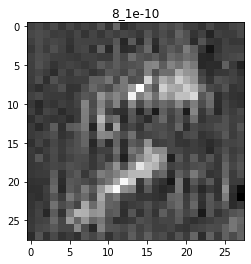

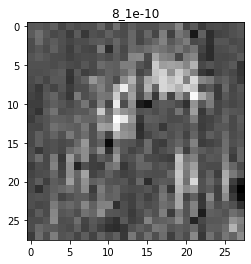

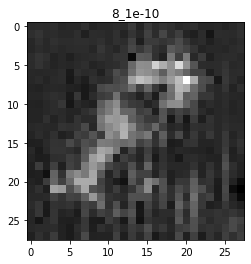

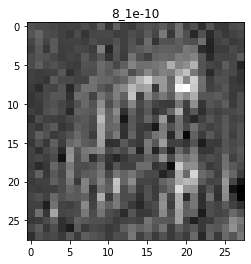

In [9]:
for size in [1,2,4,8]:#,16,32]:
    for lr in ['1e-10']:
        with open(f'chkpt/mnist_gmm_samples_{size}_{lr}.pickle','rb') as in_file:
            samples = pickle.load(in_file)['sample']
        for sample in samples[:10]:
            plt.imshow(sample[0], cmap='gray')
            plt.title(f'{size}_{lr}')
            plt.show()

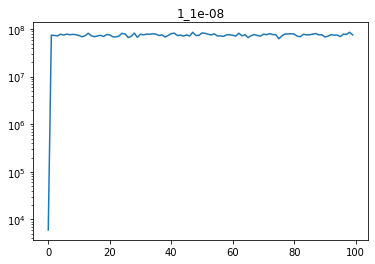

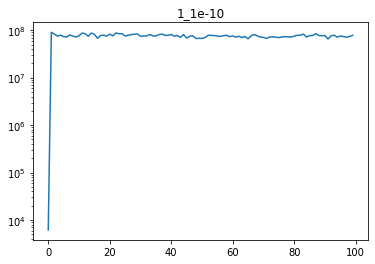

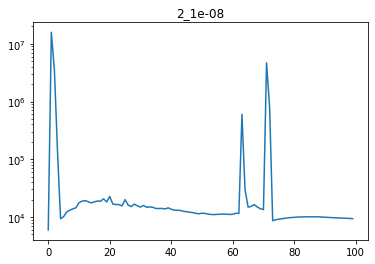

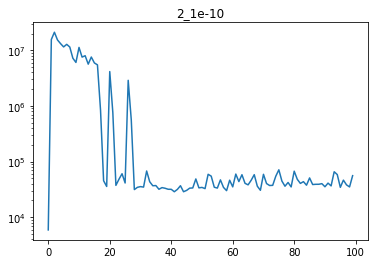

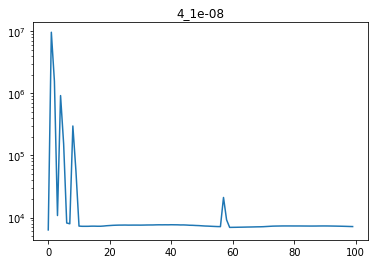

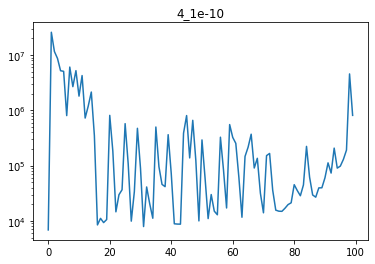

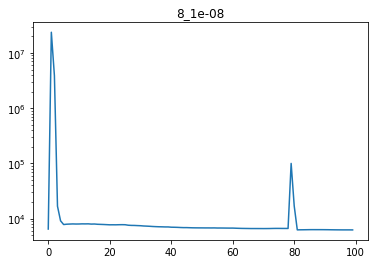

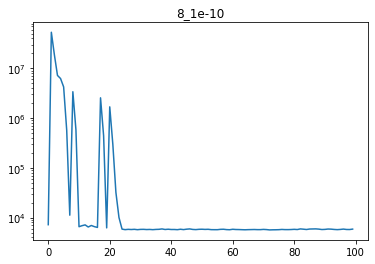

FileNotFoundError: [Errno 2] No such file or directory: 'chkpt/mnist_gmm_samples_16_1e-08.pickle'

In [7]:
for size in [1,2,4,8,16,32]:
    for lr in ['1e-08', '1e-10']:
        with open(f'chkpt/mnist_gmm_samples_{size}_{lr}.pickle','rb') as in_file:
            losses = np.array(pickle.load(in_file)['losses'])
        plt.semilogy(losses)
        plt.title(f'{size}_{lr}')
        plt.show()

In [2]:
from torchvision.transforms import transforms
import torchvision as tv


def get_mnist(batch_size):
  transform = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize((0.1307,), (0.30811,))
    ]
  )

  train_set = tv.datasets.MNIST(
    '../data/', train=True, download=True, transform=transform
  )
  test_set = tv.datasets.MNIST(
    '../data/', train=False, download=True, transform=transform
  )

  train_loader = torch.utils.data.DataLoader(
    train_set, batch_size
  )
  test_loader = torch.utils.data.DataLoader(
    test_set, batch_size
  )

  return train_loader, test_loader

In [3]:
from tqdm import tqdm
def fit_gmm(model, train_loader, num_epochs=10):

  with tqdm(total=num_epochs) as progress:
    for epoch in range(num_epochs):
      for i , (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        z, log_det = model(x)
        model.update_gmm(z)

      progress.set_description(
          f'e: {epoch}'
        )
      progress.update()
  return model


In [4]:
from acflow import RealNVP
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
layers = 8
model = RealNVP(
        1, 5, layers, 10, (1,28,28), device, 10
      ).to(device)
  
model.load_state_dict(torch.load(f'chkpt/mnist_gmm_{layers}_1e-10.tar')['model_state_dict'])
print(sum(p.numel() for p in model.parameters()))

train_loader, test_loader = get_mnist(512)
model = fit_gmm(model, train_loader, 1)

  0%|          | 0/1 [00:00<?, ?it/s]

57954


e: 0: 100%|██████████| 1/1 [02:54<00:00, 174.20s/it]


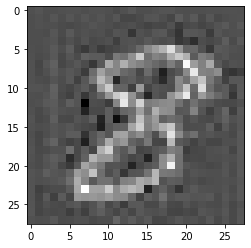

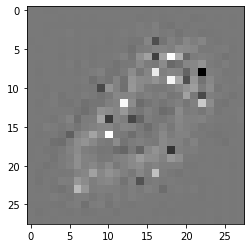

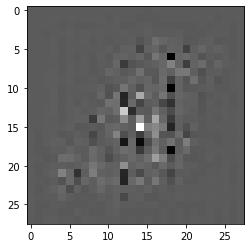

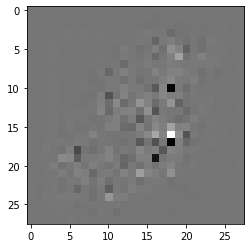

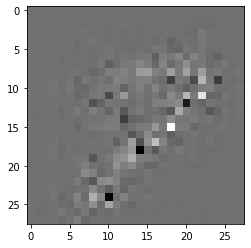

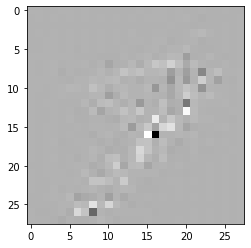

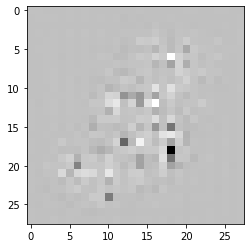

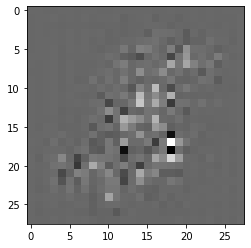

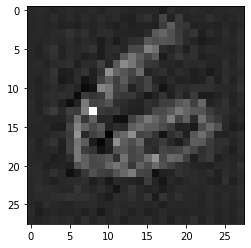

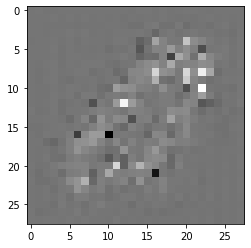

In [5]:
samples = model.sample(10)
for sample in samples:
  plt.imshow(sample.cpu().detach().numpy()[0], cmap='gray')
  plt.show()

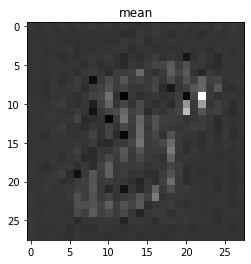

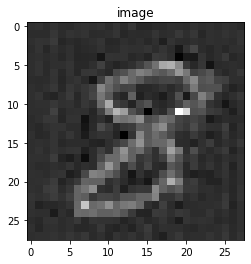

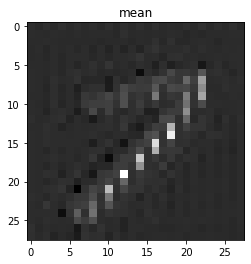

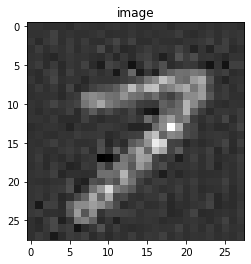

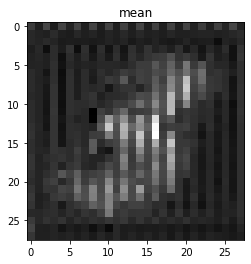

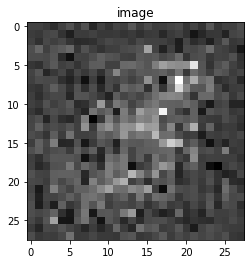

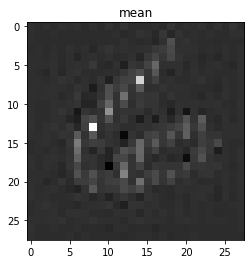

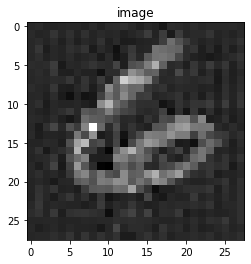

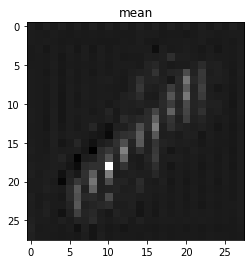

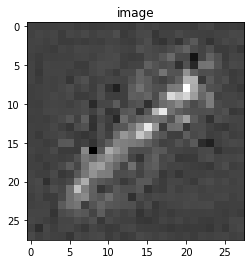

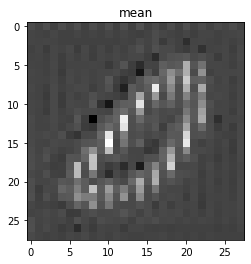

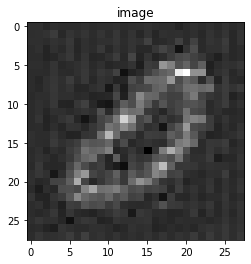

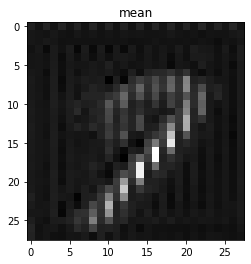

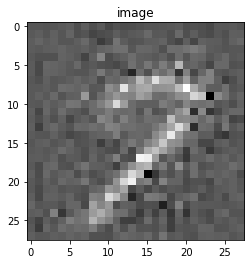

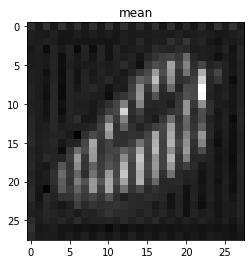

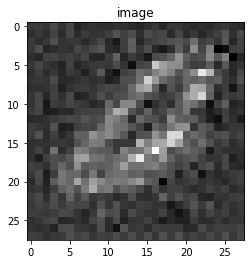

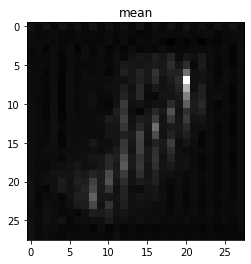

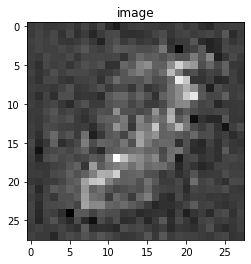

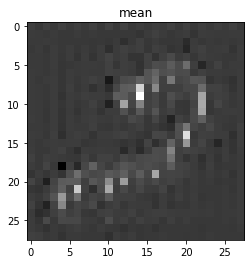

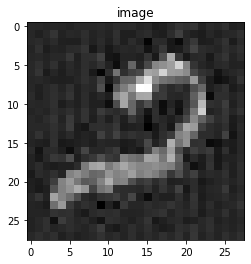

In [6]:
for mean in model.prior.mu[0]:
  plt.imshow(mean.cpu().detach().numpy().reshape((28,28)), cmap='gray')
  plt.title('mean')
  plt.show()
  image = model.reverse(mean.view((1,28,28)))
  plt.imshow(image.cpu().detach().numpy().reshape((28,28)), cmap='gray')
  plt.title('image')
  plt.show()